In [34]:
%pylab inline
import numpy as np
import torch
import os
import pandas as pd

from torch import nn
from torch import optim
from torch.nn import functional as F
from torch import autograd
from torch.autograd import Variable
import nibabel as nib
from torch.utils.data.dataset import Dataset
from torch.utils.data import dataloader

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
from nilearn import plotting
from ADNI_dataset import *
from BRATS_dataset import *
from ATLAS_dataset import *
from Model_alphaWGAN import *
from utils import *

import pytorch_ssim
from ipdb import set_trace

Populating the interactive namespace from numpy and matplotlib


# Configuration

In [35]:
# used to store the MMD ans MS-SSIM
try:
    os.mkdir('./test_data')
except FileExistsError:
    pass
workers = 4
BATCH_SIZE = 6
latent_dim = 1000

Use_BRATS = False
Use_ATLAS = False
gpu = 3

In [36]:
trainset = ADNIdataset(augmentation=True)
train_loader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,
                                          shuffle=True,num_workers=workers)
#'flair' or 't2' or 't1ce'
# trainset = BRATSdataset(imgtype='flair')
# train_loader = torch.utils.data.DataLoader(trainset,batch_size = BATCH_SIZE, shuffle=True,
#                                                num_workers=workers)

# trainset = ATLASdataset(augmentation=True)
# train_loader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,
#                                           shuffle=True,num_workers=workers)

gen_load = inf_train_gen(train_loader)

## Pre-trained Generator Load

In [25]:
#-------------------------------------------
#Choose the Model you want!
from Model_alphaWGAN import *
# from Model_alphaWGAN import Discriminator
# from Model_alphaGAN import Generator
# from Model_VAEGAN import Generator
# from Model_VAEGAN import Encoder
# from Model_WGAN import Generator
#-------------------------------------------

G = Generator(noise=latent_dim).cuda(gpu)
# E = Encoder(out_class = latent_dim).cuda(gpu)
E = Discriminator(out_class = latent_dim, is_dis=False).cuda(gpu)
#-----------------------
#Load Pre-trained model
#-----------------------

#------------Trained Model of ADNI dataset---------------------
# G.load_state_dict(torch.load('./checkpoint/G_iter188500.pth')) # Alpha-WGAN-GP
# E.load_state_dict(torch.load('./trained/E_iter12500.pth')) # Alpha-WGAN-GP Encoder
# G.load_state_dict(torch.load('./wl_checkpoint/G_iter42000.pth')) #VAE-GAN
# G.load_state_dict(torch.load('./vae_checkpoint_1/G_VG_ep_299.pth')) #Alpha-GAN
# G.load_state_dict(torch.load('./checkpoint/G_W_iter3000.pth')) #WGAN-GP

#------------Trained Model of ATLAS dataset---------------------
# G.load_state_dict(torch.load('./checkpoint/Ours_at_G.pth'))

#------------Trained Models of BRATS dataset---------------------
# G.load_state_dict(torch.load('./checkpoint/Ours_fl_G.pth'))
# G.load_state_dict(torch.load('./checkpoint/Ours_t2_G.pth'))

Fake Image - slice series visualization

You can change the axis (x , y , z ) by changing  display_mode = 'x' / 'y' / 'z'

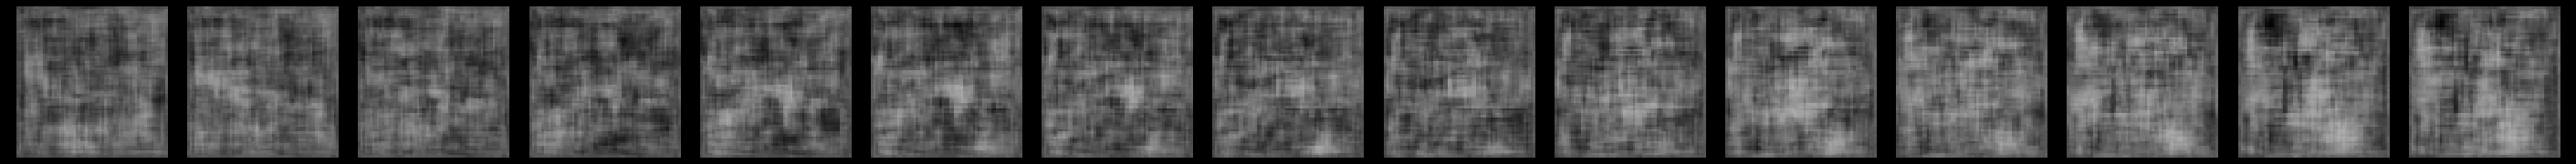

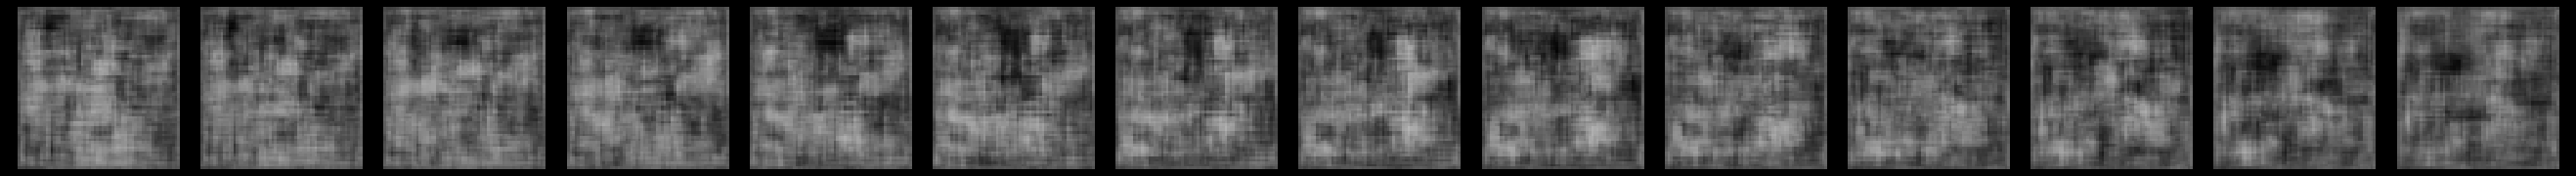

In [30]:
Show_color = False

noise = torch.randn(1, latent_dim).cuda(gpu)
fake_image = G(noise)
featmask = np.squeeze(fake_image[0].data.cpu().numpy())
featmask = nib.Nifti1Image(featmask,affine = np.eye(4))

arr1 = [4,6,8,10,12,14,16,18,20,22,24,26,28,30,32]
arr2 = [34,36,38,40,42,44,46,48,50,52,54,56,58,60]
if Show_color:
    disp = plotting.plot_img(featmask,cut_coords=arr1,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False,positions=True)
    plotting.show()
    disp=plotting.plot_img(featmask,cut_coords=arr2,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False)
    plotting.show()
else:
    disp = plotting.plot_anat(featmask,cut_coords=arr1,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    plotting.show()
    # disp.annotate(size=25,left_right=False)
    disp=plotting.plot_anat(featmask,cut_coords=arr2,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False)
    plotting.show()

Fake Image - Center cut slices Visualization

In [ ]:
noise = Variable(torch.randn((1, 1000)).cuda(gpu))
# fake_image = G(noise)
featmask = np.squeeze(fake_image[0].data.cpu().numpy())
featmask = nib.Nifti1Image(featmask,affine = np.eye(4))
plotting.plot_img(featmask,cut_coords=(32,32,32),draw_cross=False,annotate=False,black_bg=True)
plotting.plot_anat(featmask,cut_coords=(32,32,32),draw_cross=False,annotate=False,black_bg=True)
plotting.show()

Real Image - Slice series visualization

In [ ]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=2, shuffle=True, num_workers=workers)

Show_color = False

image = gen_load.__next__()
featmask = np.squeeze(image[0].data.cpu().numpy())
featmask = nib.Nifti1Image(featmask,affine = np.eye(4))
arr1 = [4,6,8,10,12,14,16,18,20,22,24,26,28,30,32]
arr2 = [34,36,38,40,42,44,46,48,50,52,54,56,58,60]

if Show_color:
    disp = plotting.plot_img(featmask,cut_coords=arr1,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False,positions=True)
    plotting.show()
    disp=plotting.plot_img(featmask,cut_coords=arr2,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False)
    plotting.show()
else:
    disp = plotting.plot_anat(featmask,cut_coords=arr1,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    plotting.show()
    # disp.annotate(size=25,left_right=False)
    disp=plotting.plot_anat(featmask,cut_coords=arr2,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False)
    plotting.show()

# MS-SSIM Calculation

In [ ]:
G.load_state_dict(torch.load('./trained/G_VG_ep_99.pth'))
sum_ssim = 0
for i in range(1000):
    noise = Variable(torch.randn((2, 1000)).cuda(gpu))
    images = gen_load.__next__().cuda(gpu)
#   images = G(noise)
    img1 = images[0]ggb
    img2 = images[1]

    msssim = pytorch_ssim.msssim_3d(img1,img2)
    sum_ssim = sum_ssim+msssim
    if i % 100 == 0:
        print(sum_ssim/1000)
print(f'final ssim: {sum_ssim/1000}')

# MS-SSIM Curve

In [ ]:
ssim_pth = 'wl_checkpoint_mse'
G.load_state_dict(torch.load(f'./{ssim_pth}/G_iter1000.pth'))
calc_ssim(G, 1000, ssim_pth, no_write=False, gpu=gpu)
# for i in range(1, 301, 2):
for i in range(35000, 200001, 5000):
#     G.load_state_dict(torch.load(f'./{ssim_pth}/G_VG_ep_{i}.pth'))
    G.load_state_dict(torch.load(f'./{ssim_pth}/G_iter{i}.pth'))
    calc_ssim(G, i, ssim_pth, no_write=False, gpu=gpu)

In [ ]:
# MS-SSIM Curve

# MS-SSIM for real images

In [ ]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=2, shuffle=True, num_workers=workers)
test_loader = inf_train_gen(train_loader)

i = 0
sum_ssim = 0
while i < 494:
    img1, img2 = test_loader.__next__()
    msssim = pytorch_ssim.msssim_3d(img1,img2)
    sum_ssim = sum_ssim+msssim
    i += 1
    if i % 100 == 0:
        print(i, sum_ssim/ (494 * 2))
        
train_loader = torch.utils.data.DataLoader(trainset, batch_size=2, shuffle=True, num_workers=workers)
test_loader = inf_train_gen(train_loader)
while i < 494 * 2:
    img1, img2 = test_loader.__next__()
    msssim = pytorch_ssim.msssim_3d(img1,img2)
    sum_ssim = sum_ssim+msssim
    i += 1
    if i % 100 == 0:
        print(i, sum_ssim/ (494 * 2))
print(sum_ssim/(494 * 2))

# Maximum-Mean Discrepancy Score

### create mmd cruve

In [ ]:
mode ='multiscale'
mmd_pth = 'wl_checkpoint/'
last_ind = int(read_mmd(mmd_pth, name=f'{mode}_mmd.csv'))
end = 100001
if not last_ind:
    inds = [1000] + list(range(5000, end, 5000))
elif last_ind == 1000:
    inds = range(5000, end, 5000)
else: 
    inds = range(last_ind + 5000, end, 5000)
for i in inds:
    i = int(i / 1000) if 'vae' in mmd_pth else i
    G.load_state_dict(torch.load(f'./{mmd_pth}/G_iter{i}.pth'))
#     G.load_state_dict(torch.load(f'./{mmd_pth}/G_VG_ep_{i}.pth'))
    calc_mmd(train_loader, G, i, count=10, gpu_ind=gpu, mode=mode, path=mmd_pth, no_write=False)


iteration: 1000, count: 0, Mean: 0.09161635488271713, cost 46.48115372657776 seconds

iteration: 1000, count: 1, Mean: 0.09104237705469131, cost 50.25205969810486 seconds

iteration: 1000, count: 2, Mean: 0.09226517379283905, cost 48.714797258377075 seconds

iteration: 1000, count: 3, Mean: 0.09550680220127106, cost 47.423779249191284 seconds

iteration: 1000, count: 4, Mean: 0.09274329245090485, cost 47.905245304107666 seconds

iteration: 1000, count: 5, Mean: 0.09682750701904297, cost 50.01493430137634 seconds

iteration: 1000, count: 6, Mean: 0.09591618925333023, cost 53.576058864593506 seconds

iteration: 1000, count: 7, Mean: 0.09410861134529114, cost 54.38765001296997 seconds

iteration: 1000, count: 8, Mean: 0.09595966339111328, cost 55.19061851501465 seconds

iteration: 1000, count: 9, Mean: 0.09027699381113052, cost 54.87292504310608 seconds
Total_mean:0.09362629652023316 STD:0.0022197200868824965

iteration: 5000, count: 0, Mean: 0.055509697645902634, cost 54.24287796020508 

### visualize mmd curve

In [ ]:
df = load_csv('./trained/wl_gan_mmd.csv')
plt.figure()
df['mmd_score'].plot()

### alpha gan Images PCA Visualization

index: 100000, sample_mean: -0.8692697882652283 sample_var: 0.051492322236299515, yellow_mean: -0.8593531847000122 yellow_var: 0.055909279733896255


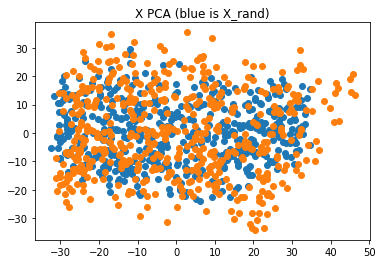

index: 95000, sample_mean: -0.8664859533309937 sample_var: 0.05300401151180267, yellow_mean: -0.8589572906494141 yellow_var: 0.05619293078780174


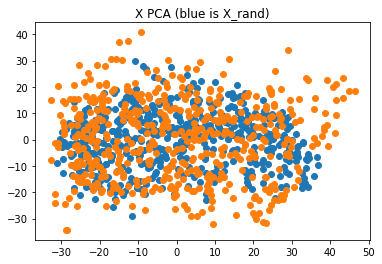

index: 90000, sample_mean: -0.8549327850341797 sample_var: 0.05821307748556137, yellow_mean: -0.8585255742073059 yellow_var: 0.05661888048052788


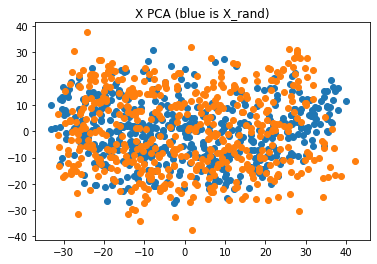

index: 85000, sample_mean: -0.8720090389251709 sample_var: 0.047727130353450775, yellow_mean: -0.8589111566543579 yellow_var: 0.05625450611114502


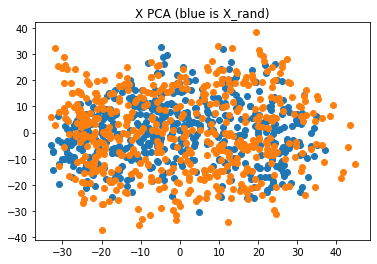

KeyboardInterrupt: 

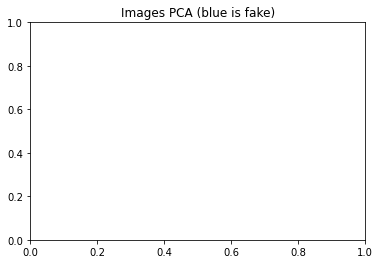

In [15]:
for i in range(100000, 0, -5000):
# for i in range(122, -1, -10):
    G.load_state_dict(torch.load(f'./wl_checkpoint/G_iter{i}.pth'))
    viz_pca(G, trainset, latent_size=latent_dim, index=i, gpu_ind=gpu)

### vaegan Images PCA Visualization

In [ ]:
for i in range(299, -1, -10):
    G.load_state_dict(torch.load(f'./vae_checkpoint_1/G_VG_ep_{i}.pth'))
    viz_pca(G, trainset, latent_size=latent_dim, index=i, gpu_ind=gpu)

In [ ]:
def show_pca_cluster(x, PC_list, interval=3):
    for i in range(x, x+interval):
        sample_ind = PC_list[i][2]
        feat = sample_df.iloc[int(sample_ind)].to_numpy().reshape((64, 64, 64))
        featmask = nib.Nifti1Image(feat,affine = np.eye(4))
        plotting.plot_img(featmask, title=f'x_val: {round(PC_list[i][0], 2)} y_val: {round(PC_list[i][1], 2)} sample_index: {int(sample_ind)}')
        plotting.show()

# concatenate the sample index 
PC_list = list(np.concatenate((PCs, np.array([i for i in range(512)]).reshape(512, 1)), 1))
# sort by x or y of PCAs
PC_list.sort(key=lambda x: x[1])

# for i in range(0, 512, 60):
#     show_pca_cluster(i, PC_list, 1)

show_pca_cluster(0, PC_list, 10)



### visualize all training images

In [ ]:
viz_all_imgs('../../ADNI', [0])

### loss check

In [ ]:
loss_df = load_loss(path='./wl_checkpoint/loss.csv')
# print(loss_df)
# alpha_wgan
loss_df[['d_fake', 'd_real_loss', 'd_recon', 'err_enc']].plot() 
# vae_gan
# loss_df[['d_real_loss', 'd_fake', 'd_recon', 'err_enc']].plot() 

# plt.figure()
# # loss_df[['loss1', 'mmd_loss']].plot()
# plt.figure()
# loss_df[['gp_r', 'gp_h', 'l1_loss']].plot()
plt.figure(figsize=(400, 400))
loss_df.plot()

### latent vector pca

<Figure size 432x288 with 0 Axes>

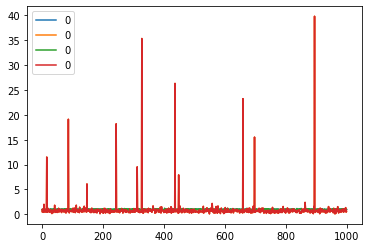

index: 100000, sample_mean: -0.0684133917093277 sample_var: 1.9382199048995972, yellow_mean: 9.220227366313338e-05 yellow_var: 0.9963799118995667


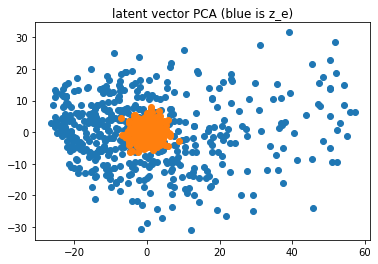

In [8]:
E.load_state_dict(torch.load(f'./wl_checkpoint_2/E_iter100000.pth'))
viz_pca(E, trainset, latent_size=latent_dim, index=100000, is_cd=True, gpu_ind=gpu)

In [ ]:
# for VAEGAN
for i in range(299, -1, -10):
    E.load_state_dict(torch.load(f'./vae_checkpoint_1/E_VG_ep_{i}.pth'))
    viz_pca(E, trainset, latent_size=latent_dim, index=i, is_cd=True, gpu_ind=gpu, batch_size=4)

In [ ]:
# for AlphaWGAN
for i in range(42000, 0, -2000):
    E.load_state_dict(torch.load(f'./wl_checkpoint/E_iter{i}.pth'))
    viz_pca(E, trainset, latent_size=latent_dim, index=i, is_cd=True, gpu_ind=gpu)

### delete CD and D

# Calculate the paddings of fake images

In [ ]:
G = Generator(noise=1000).cuda(gpu)
G.load_state_dict(torch.load('./trained/G_iter12500.pth'))

def get_padding(feat, axis=0):
    feat = np.swapaxes(feat, 0, axis)
    output = [0, 0]
    for i in range(feat.shape[0]):
#         print(feat[i].sum())
        if feat[i].sum() > -4000:
            output[0] = i
            break
    for i in range(feat.shape[0] - 1, -1, -1):
        if feat[i].sum() > -4000:
            output[1] = feat.shape[0] - i - 1
            break
    return output
    
for i in range(512):
    noise = torch.rand((1, 1000)).cuda(gpu)
    img = G(noise)
    featmask = np.squeeze((0.5*img+0.5).detach().cpu().numpy())
    print(f'ind: {i} padding 0-axis: {get_padding(featmask, 0)}', end=' ')
    print(f'ind: {i} padding 1-axis: {get_padding(featmask, 1)}', end=' ')
    print(f'ind: {i} padding 2-axis: {get_padding(featmask, 2)}')
#     featmask = nib.Nifti1Image(featmask,affine = np.eye(4))
#     plotting.plot_img(featmask, title=f'ind: {i}')
#     plotting.show()

### intensity range check

In [ ]:
trainset = ADNIdataset(augmentation=True, img_size=64, normalization=False)
train_loader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,
                                          shuffle=True,num_workers=workers)
for featmask in inf_train_gen(train_loader):
#     noise = torch.rand((1, 1000)).cuda()
#     featmask= G(noise)
#     featmask = np.squeeze((0.5*featmask+0.5).detach().cpu().numpy())
    lo, hi = featmask.min(), featmask.max()
    print(f'lo: {lo} hi: {hi}')
#     featmask = nib.Nifti1Image(featmask,affine = np.eye(4))
#     plotting.plot_img(featmask, title=f'ind: {i}')
#     plotting.show()
    

In [ ]:
%debug

In [ ]:
from utils import sinkhorn_pointcloud as sp
import numpy as np
import torch
from ipdb import set_trace
from torch import optim
from torch.autograd import Variable

gpu=1
a = Variable(torch.randn((1000, 4)).cuda(gpu), requires_grad=True)
b = Variable(torch.randn((1000, 4)).cuda(gpu) * 0.01, requires_grad=True) 
g_optimizer = optim.Adam([a, b], lr=0.0002)
print(a.shape, b.shape)
for i in range(1000):
    g_optimizer.zero_grad()
    w_dist = sp.sinkhorn_loss(a, b, 0.1, 1000, 100, gpu=gpu)
    w_dist.backward()
    g_optimizer.step()
    
    if i % 100 == 0:
        print(w_dist)

In [ ]:
a = torch.randn((1, 5), requires_grad=True)
c = a * 2
c.requires_grad = True;
b = c.sum()
b.backward()
print(a.grad)
print(c.grad)
print(b.grad)
